## Accelegrad vs UnixGrad Analysis 

#### Import Libraries 

In [5]:
import os
import sys
import numpy as np
from scipy import sparse 
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from tqdm.notebook import tqdm


module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
print("Main Directory: ", module_path)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Main Directory:  /Users/marcellobullo/Desktop/optimization/Optimization


In [6]:
def load_data( path ):

    # import
    data = pd.read_csv( path, delimiter=',')
    data = data.drop('id', axis=1)
    data = data.drop('Unnamed: 32', axis=1)
    data['diagnosis'] = np.array(data['diagnosis'].map(lambda x: 1 if x=='M' else -1))
    
    features = np.array(data)[:,1:]
    
    # normalization
    scaler = preprocessing.StandardScaler().fit(features)
    features = scaler.transform(features)
    
    b = np.ones(len(features)).reshape(-1,1)
    features = np.hstack((features,b))
    
    # labels
    labels = np.array(data)[:,0]
    labels[labels==0] = -1
    labels = labels.reshape((-1,1))

    return shuffle(features, labels)

In [7]:
X, y = load_data( os.path.join(module_path,"datasets/data.csv") )
print("Dataset shape: ", X.shape)
print("Labels shape: ", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("TRAIN len: ", len(X_train))
print("TEST len: ", len(X_test))
#initialize initial weights as a sparse matrix. 
weights_initial = np.random.rand(1,X.shape[1]).T
print("Weights shape: ", weights_initial.shape)

Dataset shape:  (569, 31)
Labels shape:  (569, 1)
TRAIN len:  455
TEST len:  114
Weights shape:  (31, 1)


In [8]:
#d = 2
#n = 50
#mean = np.zeros(d)
#sigma = 1.1
#cov = (sigma**2)*np.eye(d)   
#x1 = np.random.multivariate_normal(mean, cov, n)
#l1 = np.ones(len(x1))
#
#mean = 10*np.ones(d)
#sigma = 2
#cov = (sigma**2)*np.eye(d)
#x2 = np.random.multivariate_normal(mean, cov, n)
#l2 = (-1)*np.ones(len(x2))
#
#data = np.concatenate((x1,x2), axis=0 )
#labels = np.concatenate((l1,l2), axis=0 ).reshape(-1,1)
#print(labels.shape)
#
#plt.scatter(data[:,0],data[:,1], c = labels)
#plt.title("Original data")
#plt.show()
#
#
#scaler = preprocessing.StandardScaler().fit(data)
#data = scaler.transform(data)
#
#plt.scatter(data[:,0],data[:,1], c=labels)
#plt.title("Scaled data")
#plt.show()
#
## Add homogeneous coord
#b = np.ones(len(data)).reshape(-1,1)
#data = np.hstack((b, data))
#
#
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
#print("TRAIN len: ", len(X_train))
#print("TEST len: ", len(X_test))
##initialize initial weights as a sparse matrix. 
#weights_initial = np.random.rand(1,data.shape[1]).T
#print("Weights shape: ", weights_initial.shape)

In [9]:
def gen_least_square_data(n, d, R):
    """Generate a sintethic dataset which solution
    is given by a least square problem minimization.
    Input:
        n = number of samples
        d = dimension of dataset
        R = Diameter of the ball 
    Output:
        x_star = Optimal weights 
        f_star = minimum achievable error
        A = Matrix
        b = vector
    """
    mean = np.zeros(d)
    sigma = 1
    cov = (sigma**2)*np.eye(d)
    x_mus = np.random.normal(0,1,d).reshape(-1,1)
    eps = np.random.normal(0,1e-03,n).reshape(-1,1)
    
    A = np.random.multivariate_normal(mean, cov, n)
    
    b = np.dot(A,x_mus) + eps

    x_star = np.dot( np.dot( np.linalg.inv( np.dot(A.T, A) ), A.T), b )
    if(np.linalg.norm(x_star) > R):
        x_proj = gradient_projection(x_star, d)
    f_star = (1/2*n)*np.linalg.norm(np.dot(A, x_star) - b, ord=2)
    
    return A, b, x_star, f_star


def batch_gen(data,labels,batch_size):
    num_batches = len(data)//batch_size
    return np.split(data[:num_batches*batch_size], num_batches, axis=0), np.split(labels[:num_batches*batch_size], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def squared_hinge_loss(x, w, y, l):
    """Squared hinge loss function + L2 Regularization. 
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """
    m = len(y)
    loss = (1/m) * np.sum( np.maximum( 0, 1 - y*np.dot(x,w) )**2 ) + l * np.linalg.norm(w)**2
    return loss

def grad(x, w, y, l):
    """
    Compute the gradient of the squared hinge loss + L2 regularization
    Input:  
        x: Sample
        w: Weights
        y: True label
        l: Lambda regularization value
    Return:
        Squared hinge loss + L2 Regularization
    """    
    m = len(y)
    grad = (1/m)*np.sum( -2*np.maximum( 0, (1-y*np.dot(x,w)) * y*x ), axis=0 ) +2*l*w.T
    return grad


def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    corr, _ = np.where( (y_pred - y_test) == 0 )
    return len(corr) / len(y_pred)
    

def accelegrad(weights,
               features,
               labels,
               diameter=10**4,
               lamb=0.01,
               max_iter=100):
    
    print("*"*33)
    print("-----> ACCELEGRAD OPTIMIZER <----")
    print("*"*33)

    print("\n")

    weights = gradient_projection(weights, diameter)
    # Set loss function array
    loss = np.zeros(max_iter)
    
    # Set the array where we store each y_t value to compute the mean at the end
    # (weights x num iterations)
    ys = np.zeros((weights.shape[0],max_iter))
    
    # Initial weights
    x_i = weights[:,0]
    ybar = weights[:,0]
    S2 = 0
    
    # Set the gradient history (weights x num iterations)
    grad_hist = np.zeros((weights.shape[0],max_iter))
    #print('feature shape',features.shape)
    #print('weigths shape',weights.shape)
    #print('labels shape',labels.shape)
    #print('lamb shape',labels.shape)
    grad_hist[:,0] = grad(features, weights, labels, lamb)
    
    # Set y_t and z_t equal to the initial weights
    ys[:,0] = x_i
    z_i = x_i
    
    # Set alpha weights
    alpha_weights = np.ones(max_iter)
    for t in range(3,max_iter):
        alpha_weights[t] = 1/4*(t+1)
        
    # Set tau
    tau = np.zeros(max_iter)
    for t in range(max_iter):
        tau[t] = 1/alpha_weights[t]
                
    # Set initial Step Size
    step_size = diameter/np.sqrt( (alpha_weights[0]**2)*np.linalg.norm(grad_hist[:,0])**2 )
    
    print("\n --- INITIAL STEP SIZE ---> ",step_size)
    # Build the batches of size 5
    batches, labels = batch_gen(features,labels,64)
        
    for i in range(1,max_iter):
        
        #print("\n\n----- ITER {} -----".format(i))

        
        # Select a batch at random:
        batch, lab = random_batch_selection(batches,labels)
        # Compute x_t
        x_i = tau[i] * z_i + (1 - tau[i]) * ys[:,i-1]
        #print(x_i)
        #print(ys[:,i-1])
        
        # Compute the projected gradient 
        grad_hist[:,i] = grad(batch, x_i.reshape(-1,1), lab, lamb)
        #print(grad_hist)
        
        # Update Step size
        step_size = diameter/ np.sqrt( np.sum( (alpha_weights[:i]**2)*np.linalg.norm(grad_hist[:,i],axis=0)**2 ) )
        #print(step_size)
        
        # Compute z_t
        z_i = gradient_projection( z_i - alpha_weights[i]*step_size*grad_hist[:,i], diameter )
        
        # Compute y_t
        ys[:,i] = x_i - step_size*grad_hist[:,i]
        
        # Update loss
        #print(alpha_weights[:i].shape)
        #print(ys[:,:i].shape)
        #print(1/i * np.sum(alpha_weights[:i] * ys[:,:i], axis=1))
        #a = (1/i) * np.sum(alpha_weights[:i] * ys[:,:i], axis=1)
        #avg = 1/i * np.sum(alpha_weights[:i] * ys[:,1:i+1], axis=1)
        #print(ys[:,i])
        
        S2 = S2 + alpha_weights[i]
        weight = alpha_weights[i]/S2
        ybar =  (1 - weight)*ybar + weight*ys[:,i]
        
        

        loss[i] = squared_hinge_loss(batch, ybar, lab, lamb)
        
    
    return loss, np.sum(alpha_weights[:-1] * ys[:,1:], axis=1)

In [419]:
def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    return (np.count_nonzero( (y_pred - y_test) == 0 ) / len(y_pred))*100
    #corr, _ = np.where( (y_pred - y_test) == 0 )
    #return len(corr) / len(y_pred)

def batch_gen(data,labels,batch_size):
    num_batches = len(data)//batch_size
    return np.split(data[:num_batches*batch_size], num_batches, axis=0), np.split(labels[:num_batches*batch_size], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def compute_grad(w, lamb, x, y):
    w = w[:,0]
    yx = y*x
    yxw = yx.dot(w)
    compare_result= np.maximum(0, 1-yxw)
    part1 = -2/len(y)*compare_result.dot(yx)
    part2 = 2*lamb*w      
    return (part1+part2)[:, np.newaxis]

def squared_hinge_loss(w, lamb, x, y):
    w = w[:,0]
    return 1/len(y) * (np.sum(
        (np.maximum(0, 1-((y*x).dot(w)))**2)))\
        + lamb * np.linalg.norm(w)**2
    
def accelegrad_v2(weights,
                  x_train,
                  y_train,
                  x_test,
                  y_test,
                  D=1,
                  G=0,
                  lamb=0.01,
                  max_iter=100):
    
    loss_hist = []
    accuracy_hist = []
    
    #x0 = gradient_projection(weights, D)
    x0 = weights
    loss = squared_hinge_loss(x0, lamb, x_train, y_train)
    loss_hist.append(loss)
    print("ACCELERATED LOSS:", loss)
    #print(x0)


    xt = yt = zt = ybar = x0
    S1 = 0
    S2 = 0
    train_batches, train_labels = batch_gen(x_train, y_train, 5)
    
    for t in range(max_iter+1):
        
        prediction = predict(x_test, ybar)
        accuracy_hist.append( get_accuracy( prediction, y_test) )
        
        batch, label = random_batch_selection(train_batches, train_labels)
        
        alphat = np.maximum( 0.25*(t+1), 1 )
        taut = 1/alphat
        
        # Update
        xt = taut * zt + (1-taut)*yt
        
        # Compute the subgradient
        gt = compute_grad(xt, lamb, batch, label)
        
        ng = np.linalg.norm(gt)

        S1 = S1 + (alphat*ng)**2
        
        etat = D/np.sqrt( 2*(G**2 + S1) )
        zt = gradient_projection(zt - alphat*etat*gt,D)
        
        yt = xt - etat*gt
        
        # Averaged
        S2 = S2 + alphat
        weight = alphat/S2
        ybar =  (1 - weight)*ybar + weight*yt
        
        #loss = squared_hinge_loss(ybar, lamb, batch, label)
        loss = squared_hinge_loss(ybar, lamb, x_train, y_train)
        loss_hist.append(loss)
        
        #prediction = predict(x_test, ybar)
        #accuracy_hist.append( get_accuracy( prediction, y_test) )
    
    return loss_hist, accuracy_hist, ybar

In [420]:
#weights_initial = np.random.rand(1, X_train.shape[1]).T
#weights_initial = np.random.randint(low=0, high=100, size=(1, X_train.shape[1])).T
#
##weights_initial = np.zeros((1, X_train.shape[1])).T
#loss_hist, acc_hist, y_bar = accelegrad_v2(weights_initial,
#                                 X_train,
#                                 y_train,
#                                 X_test,
#                                 y_test,
#                                 D=100,
#                                 G=0,
#                                 lamb=10,
#                                 max_iter=10000)
#
##y_pred = predict(X_test,y_bar)
##print(get_accuracy(y_pred,y_test))
#plt.plot(loss_hist)
#plt.grid()
#plt.yscale('log')
#plt.xscale('log')
#plt.show()
#
#
#plt.plot(acc_hist)
#plt.grid()
#plt.xlim([0,200])
#plt.show()

ACCELERATED LOSS: 88031.84035873416
ACCELERATED LOSS: 189428.43078729423
ACCELERATED LOSS: 93976.57733232543
ACCELERATED LOSS: 255709.7303060197
ACCELERATED LOSS: 204918.61862007633


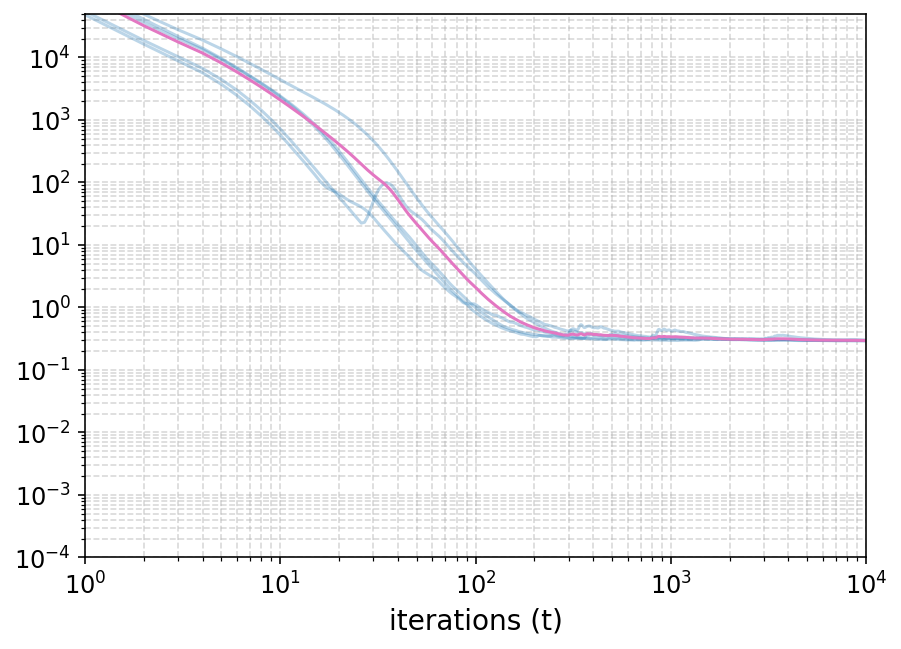

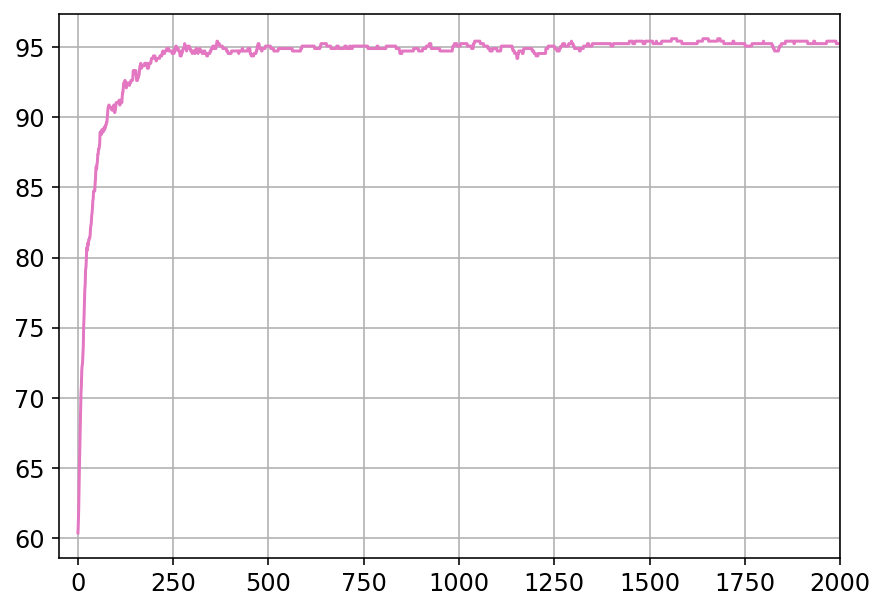

In [421]:
max_iter = 10000

plt.figure(figsize=(7,5))
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', ls="--", alpha=0.5)

losses = []
accs = []
for i in range(5):
    #weights_initial = np.random.rand(1,X_train.shape[1]).T
    #weights_initial = np.zeros((X_train.shape[1],1))
    weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T

    loss, acc, y_bar = accelegrad_v2(weights_initial,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                D=100,
                                G=0,
                                lamb=1,
                                max_iter=max_iter)
    
    plt.plot(loss, alpha=0.3, c='tab:blue')
    
    losses.append(loss)
    accs.append(acc[1:])
    
mean_loss = np.mean(losses,axis=0)
mean_acc = np.mean(accs, axis=0)


plt.plot(mean_loss, c='tab:pink')
plt.xlabel(r"iterations (t)", fontsize=14)
plt.xlim([1,max_iter])
plt.ylim([1e-4,5*1e4])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(mean_acc, c='tab:pink')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim([-50,2000])
plt.grid()
plt.show()

## UnixGrad

In [458]:
def gradient_projection(grad, diameter):
    if(np.linalg.norm(grad) <= diameter):
        return grad
    else:
        return (diameter/2)*( grad / np.linalg.norm(grad) )
    
    
def predict(x, w):
    return np.sign( np.dot(x,w) )

def get_accuracy(y_pred,y_test):
    return (np.count_nonzero( (y_pred - y_test) == 0 ) / len(y_pred))*100
    #corr, _ = np.where( (y_pred - y_test) == 0 )
    #return len(corr) / len(y_pred)

def batch_gen(data,labels,batch_size):
    num_batches = len(data)//batch_size
    return np.split(data[:num_batches*batch_size], num_batches, axis=0), np.split(labels[:num_batches*batch_size], num_batches, axis=0)

def random_batch_selection(batches, labels):
    num_batches = len(batches)
    idx = np.random.randint(0, num_batches)
    return batches[idx], labels[idx]

def compute_grad(w, lamb, x, y):
    w = w[:,0]
    yx = y*x
    yxw = yx.dot(w)
    compare_result= np.maximum(0, 1-yxw)
    part1 = -2/len(y)*compare_result.dot(yx)
    part2 = 2*lamb*w      
    return (part1+part2)[:, np.newaxis]

def squared_hinge_loss(w, lamb, x, y):
    w = w[:,0]
    return 1/len(y) * (np.sum(
        (np.maximum(0, 1-((y*x).dot(w)))**2)))\
        + lamb * np.linalg.norm(w)**2
    
def unixGrad(weights,
             x_train,
             y_train,
             x_test,
             y_test,
             D=1,
             lamb=0.01,
             max_iter=100):
    
    
    loss_hist = []
    accuracy_hist = []
    
    #x0 = gradient_projection(weights, D)
    x0 = weights
    loss = squared_hinge_loss(x0, lamb, x_train, y_train)
    print("UNIXGRAD LOSS:", loss)
    #print(x0)
    loss_hist.append(loss)

    
    
    xt = yt = gt = Mt = xtbar = x0
    
    # cumulative sum of denominator of etat (learning rate)
    S1 = 0
    
    # cumulative sum of alpha
    S2 = 0
    
    # cumulative alpha_i*x_i
    S3 = 0 
    
    train_batches, train_labels = batch_gen(x_train, y_train, 5)
    
    for t in range(1,max_iter+1):
        
        # Randomly select a batch
        batch, label = random_batch_selection(train_batches, train_labels)
        
        prediction = predict(x_test, xtbar)
        accuracy_hist.append( get_accuracy( prediction, y_test) )
        
        # Compute alphat
        alphat = t
        
        # Update cumulative alphat
        S2 = S2 + alphat
        #weight = alphat/S2
        
        # Update zbar
        ztbar =  ( alphat*yt + S3 ) / S2
        #ztbar = weight*yt + (1-weight)*ztbar
        
        # Compute gradient in zbar (Mt)
        Mt = compute_grad( ztbar, lamb, batch, label  )
        
        # Compute etat
        etat = D / np.sqrt(1 + S1)
        
        # Mirror Prox (MP) update
        xt = ( 0.5*etat ) * ( 2*yt - alphat*Mt )
        
        # Update xbar
        
        #xtbar =  (1 - weight)*xtbar + weight*xt
        xtbar = (1/S2)* ( alphat*xt + S3 )
        
        # Compute gradient in xbar
        gt = compute_grad( xtbar, lamb, batch, label  )
        
        # Mirror Prox update
        yt = ( 0.5*etat ) * ( 2*yt - alphat*gt )
        
        # Update S3
        S3 = S3 + alphat*xt

        # update S1
        nd = np.linalg.norm(gt - Mt, ord=np.inf)   
        S1 = S1 + (alphat*nd)**2
        
        # Compute the training loss
        loss = squared_hinge_loss(xtbar, lamb, x_train, y_train)
        loss_hist.append(loss)

    return loss_hist, accuracy_hist, xtbar

In [459]:
#weights_initial = np.random.rand(1, X_train.shape[1]).T
##weights_initial = np.random.randint(low=0, high=100, size=(1, X_train.shape[1])).T
#
##weights_initial = np.zeros((1, X_train.shape[1])).T
#loss_hist, acc_hist, xtbar = unixGrad(weights_initial,
#                                      X_train,
#                                      y_train,
#                                      X_test,
#                                      y_test,
#                                      D=1,
#                                      lamb=10,
#                                      max_iter=10000)
#
##y_pred = predict(X_test,y_bar)
##print(get_accuracy(y_pred,y_test))
#plt.plot(loss_hist)
#plt.grid(which='both', ls="--", alpha=0.5)
#plt.yscale('log')
#plt.xscale('log')
#plt.show()
#
#
#plt.plot(acc_hist)
#plt.grid()
##plt.xlim([0,2000])
#plt.show()

ACCELERATED LOSS: 3099.291034131803
UNIXGRAD LOSS: 3099.291034131803
ACCELERATED LOSS: 4586.288517315287
UNIXGRAD LOSS: 4586.288517315287
ACCELERATED LOSS: 7270.712323494632
UNIXGRAD LOSS: 7270.712323494632
ACCELERATED LOSS: 3061.8792002438468
UNIXGRAD LOSS: 3061.8792002438468
ACCELERATED LOSS: 4983.062690019242
UNIXGRAD LOSS: 4983.062690019242
len(losses_ug): 10001


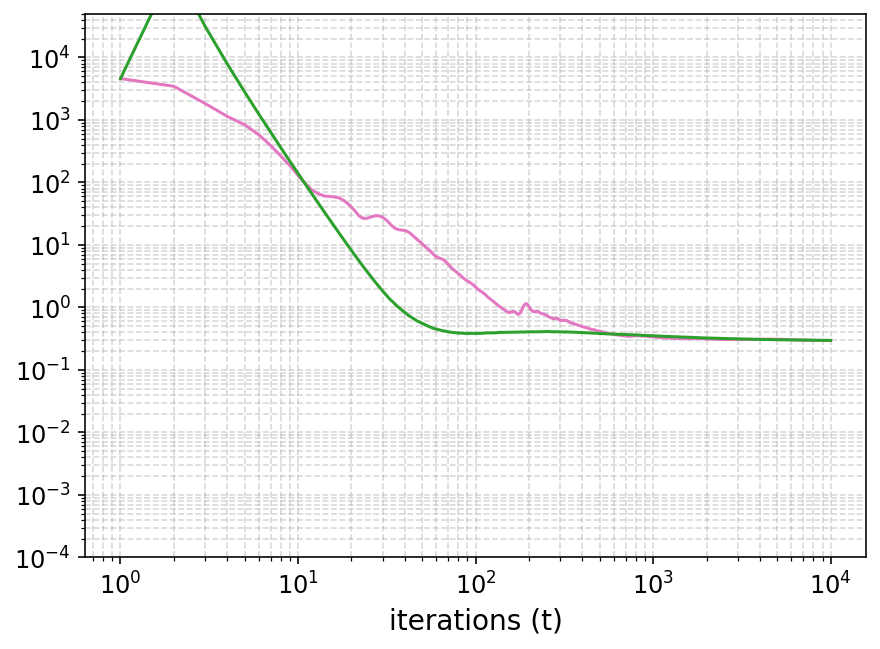

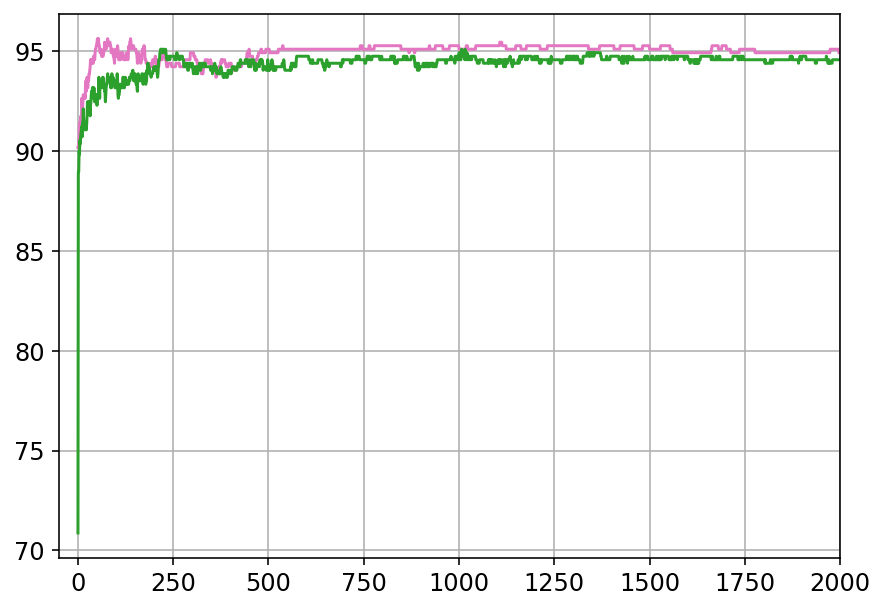

In [460]:
max_iter = 10000
D = 1e2

plt.figure(figsize=(7,5))
plt.yscale('log')
plt.xscale('log')
plt.grid(which='both', ls="--", alpha=0.5)

losses = []
accs = []

losses_ug = []
accs_ug = []
for i in range(5):
    #weights_initial = np.random.rand(1,X_train.shape[1]).T
    #weights_initial = np.zeros((X_train.shape[1],1))
    weights_initial = np.random.randint(low=-100, high=100, size=(1, X_train.shape[1])).T
    weights_initial = gradient_projection(weights_initial, D)

    loss, acc, y_bar = accelegrad_v2(weights_initial,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                D=D,
                                G=0,
                                lamb=1,
                                max_iter=max_iter)
    
    loss_ug, acc_ug, y_bar_ug = unixGrad(weights_initial,
                                         X_train,
                                         y_train,
                                         X_test,
                                         y_test,
                                         D=1,
                                         lamb=1,
                                         max_iter=max_iter)
    
    #plt.plot(loss, alpha=0.3, c='tab:blue')
    
    losses.append(loss)
    accs.append(acc[1:])
    
    losses_ug.append(loss_ug)
    accs_ug.append(acc_ug[1:])
    
mean_loss = np.mean(losses,axis=0)
mean_acc = np.mean(accs, axis=0)

print("len(losses_ug):", len(losses_ug[0]) )
mean_loss_ug = np.mean(losses_ug, axis=0)
mean_acc_ug = np.mean(accs_ug, axis=0)


plt.plot(np.arange(1,max_iter+3), mean_loss, c='tab:pink')
plt.plot(np.arange(1,max_iter+1), mean_loss_ug[:-1], c='tab:green')
plt.xlabel(r"iterations (t)", fontsize=14)
#plt.xlim([1,max_iter])
plt.ylim([1e-4,5*1e4])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(mean_acc, c='tab:pink')
plt.plot(mean_acc_ug, c='tab:green')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim([-50,2000])
plt.grid()
plt.show()

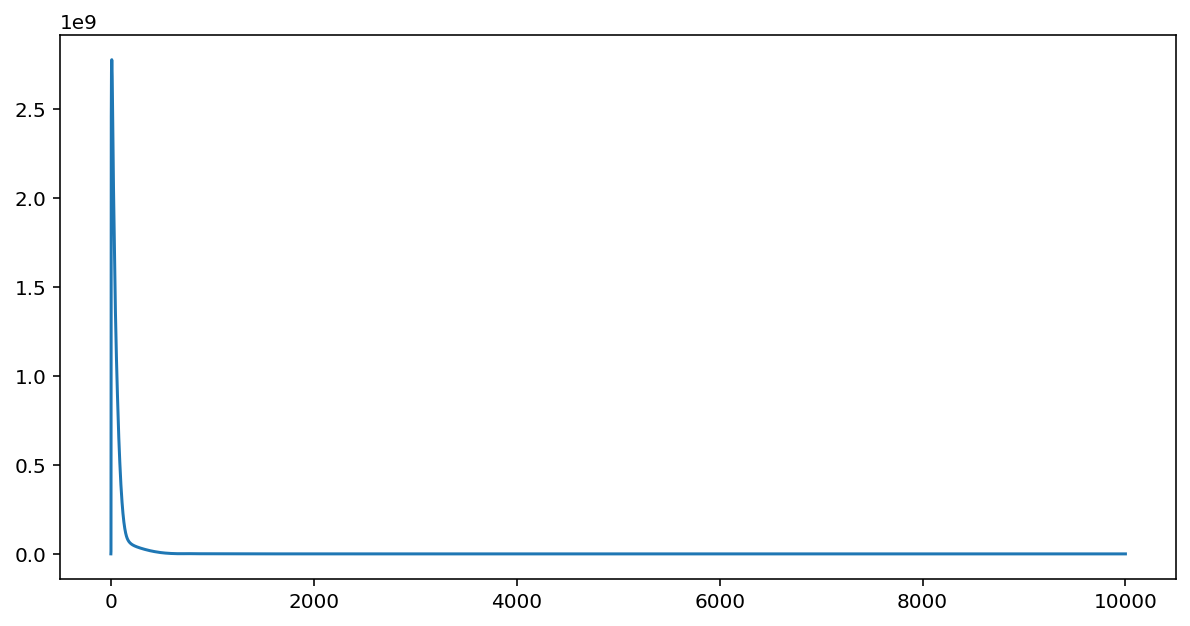

In [418]:

np.mean(losses_ug, axis=0)
plt.plot(mean_loss_ug)

In [408]:
np.arange(1,max_iter+1)

array([    1,     2,     3, ...,  9998,  9999, 10000])

In [56]:
x_ax = np.arange(-1.5,1.6,0.1)
f = -(b[0]/b[2]) - (b[1]/b[2])*x_ax
plt.scatter(data[:,1],data[:,2], c=labels)
plt.plot(x_ax, f)
plt.title("Scaled data")
plt.show()

NameError: name 'b' is not defined